In [3]:
# imports
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings
import os

## Load data

In [4]:
# load data
root = os.getcwd()
dataset_dir = os.path.join(root, 'Data-15')

In [6]:
raw_df = pd.DataFrame()

In [26]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Initialize an empty list to store data
data_list = []

list_of_folders = os.listdir(dataset_dir)

# Read matlab files
for folder in list_of_folders:
    path = os.path.join(dataset_dir, folder)
    list_of_files = os.listdir(path)
    label = str(folder)
    print(label)
    for file in list_of_files:
        if file.endswith('.mat'):
            # Read matlab file
            mat = scipy.io.loadmat(os.path.join(path, file))
            # Get data and append to the list
            data_list.append({'label': label, 'time_sig': mat['tpd']['Data'][0][0][0]})

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data_list)

# Display DataFrame description
df.describe()


Fun
HairDryer
Heater
LightBulb
Refrigirator


,label,time_sig
count,75,75
unique,5,75
top,Fun,"[-2.4666667, -2.4627452, -2.492157, -2.484314,..."
freq,15,1


In [10]:
#add fft column
df['fft'] = df['time_sig'].apply(lambda x: np.fft.fft(x))
df.head()

,label,time_sig,fft
0,Fun,"[-2.4666667, -2.4627452, -2.492157, -2.484314,...","[(198.70590213674586+0j), (-2.232318014673014+..."
1,Fun,"[-2.5058825, -2.5186276, -2.516667, -2.509804,...","[(207.29315045813564+0j), (0.06328588688745879..."
2,Fun,"[-2.4617648, -2.4627452, -2.4862747, -2.480392...","[(205.7147244606167+0j), (0.4037775054453768-1..."
3,Fun,"[-2.4715688, -2.4833336, -2.4990199, -2.512745...","[(203.39020591438748+0j), (-1.8787844941233909..."
4,Fun,"[-2.5000002, -2.527451, -2.5147061, -2.5068629...","[(206.01667345920578+0j), (0.9877989466016359+..."


TypeError: 'list' object is not callable

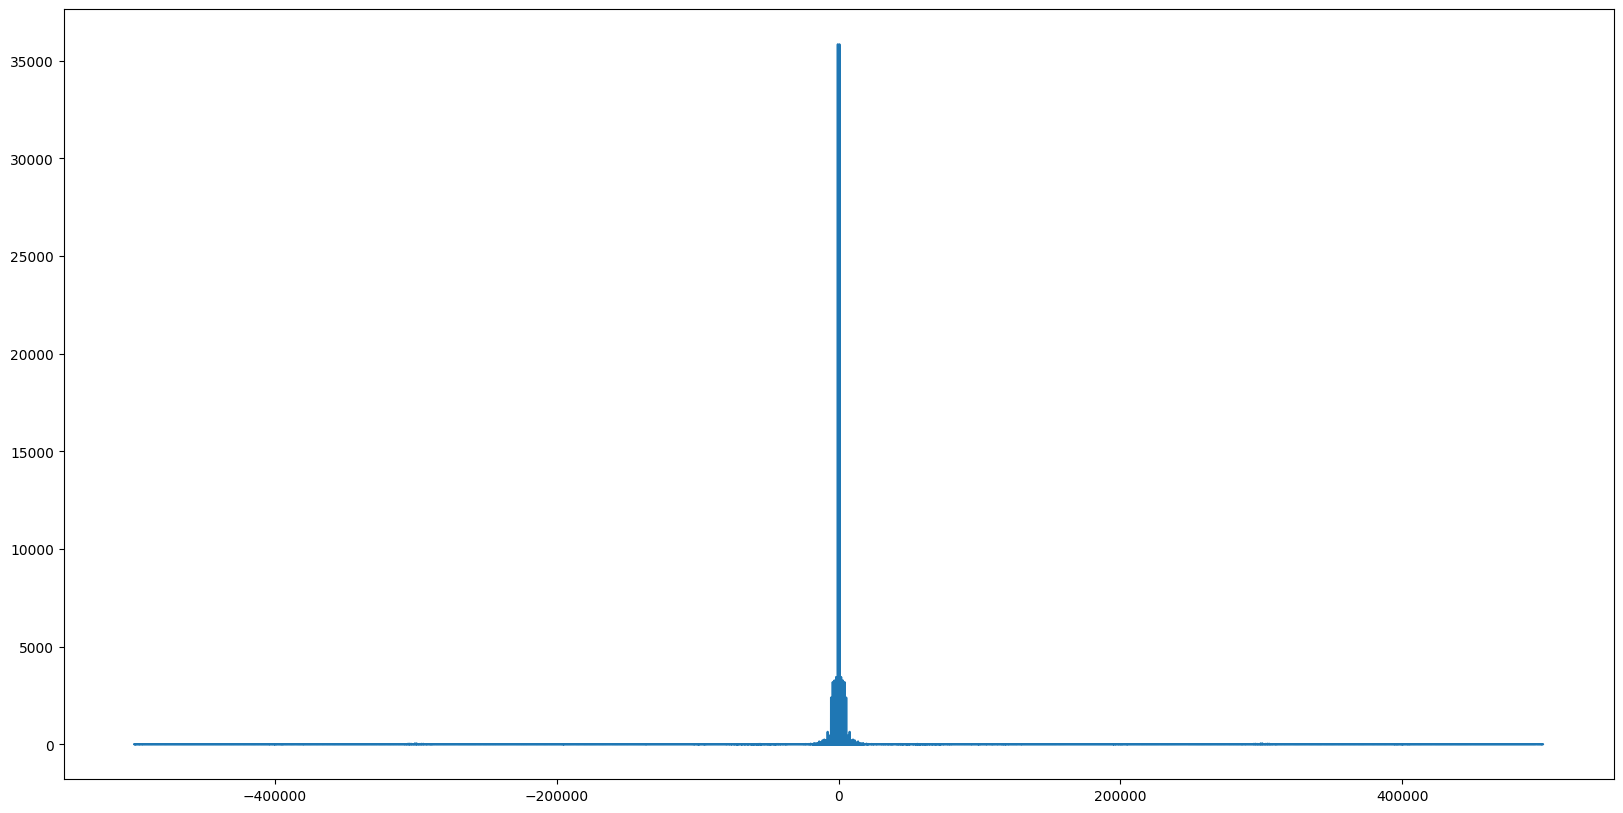

In [22]:
freqs = np.fft.fftfreq(len(df['fft'][0]), 1/1000000)
plt.figure(figsize=(20, 10))
plt.plot(freqs, abs(df['fft'][0]))
plt.xlim(0, 10000)
plt.show()

In [153]:
x = abs(np.array(df['fft'].to_list()))
#correlation matrix
x_cor = np.corrcoef(x)
x_cor.shape

(75, 75)

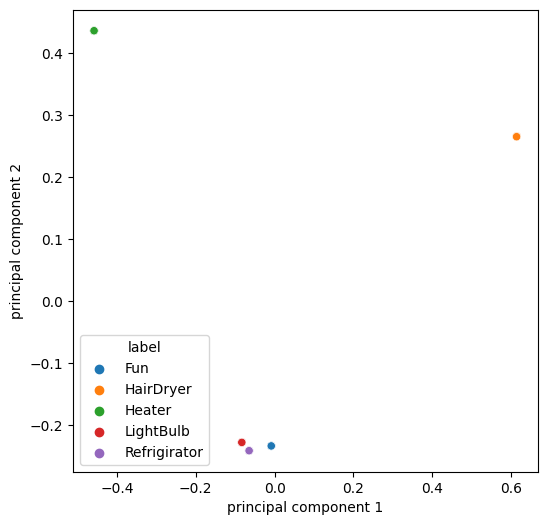

In [154]:
#apply PCA to fft column
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_cor)

#plot PCA
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()

plt.figure(figsize=(6,6))
sns.scatterplot(x=principalDf['principal component 1'], y=principalDf['principal component 2'], hue=df['label'])  
#save figure
plt.savefig('pca.png')  
plt.show()

In [88]:
print(mat['tpd'][0].dtype)

[('Name', 'O'), ('DateTime', 'O'), ('RangeMin', 'O'), ('RangeMax', 'O'), ('SampleFrequency', 'O'), ('PreSampleCount', 'O'), ('StartValue', 'O'), ('Unit', 'O'), ('Data', 'O')]


In [80]:
print(mat['tpd']['Data'][0][0][0])

[-2.0068629 -2.0049021 -2.0215688 ... -1.9588237 -2.0078433 -1.9941177]
